In [1]:
import pickle 
import yaml
import pandas as pd
from PrepareData import prepare_data


import torch
from torch import nn, optim, Tensor
from torch.nn import functional as F
import pickle 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
import seaborn as sns
from architecture import CLIP
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32


In [2]:
from train_utils import load_model

In [3]:
def make_deterministic(random_seed = 0):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    
make_deterministic(0)

In [4]:
config = yaml.safe_load(open('./checkpoints/FULL_COMBINED/config.yaml', 'r'))
logs = pickle.load(open('./checkpoints/FULL_COMBINED/logs.pickle', 'rb'))
for key in logs:
    if "best" in key:
        print(key, logs[key])

best_epoch 618
best_clip_epoch 684
best_recon_epoch 195
best_total_loss 0.05993457242846489
best_clip_loss 0.012829888865817339
best_recon_loss 0.039655369743704795


In [5]:
model = load_model(config['train']['checkpoint_dir'], type="best_clip")
model = model.eval()
dataloaders, max_charge, num_species = prepare_data(config)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [6]:
model = load_model(config['train']['checkpoint_dir'], type="best_recon")
model = model.eval()

In [7]:
val_ids = pickle.load(open('./checkpoints/FULL_COMBINED/val_ids.pickle', 'rb'))

In [8]:
all_ids = []
with torch.no_grad():
    for i, data in tqdm(enumerate(dataloaders['val'])):    
        data = {k: v.to(device) for k, v in data.items()}
        all_ids.append(data['index'].detach().cpu())
all_ids = torch.cat(all_ids, 0)

50it [00:00, 71.97it/s] 


In [9]:
assert(((val_ids.sort()[0] == all_ids.sort()[0]).sum() / all_ids.shape[0]).item())

In [10]:
from train_utils import decoder_performance
from train_utils import top_scores, decoder_performance, distance_distribution

def clip_performance(config, model, dataloaders, epoch):
    # model.to(device)
    model.eval()
    max_charge = config['data']['max_charge']
    num_species = config['data']['num_species']

    molembeds = []
    specembeds = []
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloaders['val'])):    
            data = {k: v.to(device) for k, v in data.items()}
            mol_latents, spec_latents, smile_preds, logit_scale, ids = model(data)
            molembeds.append(mol_latents.detach().cpu())
            specembeds.append(spec_latents.detach().cpu())
        del mol_latents, spec_latents, smile_preds, logit_scale, ids

    test_molembeds = torch.cat(molembeds, 0)
    test_specembeds = torch.cat(specembeds, 0)
    
    molembeds = []
    specembeds = []
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloaders['train'])):    
            data = {k: v.to(device) for k, v in data.items()}
            mol_latents, spec_latents, smile_preds, logit_scale, ids = model(data)
            molembeds.append(mol_latents.detach().cpu())
                # specembeds.append(spec_latents.detach().cpu())
        del mol_latents, spec_latents, smile_preds, logit_scale, ids
    
    train_molembeds = torch.cat(molembeds, 0)

    return test_molembeds, train_molembeds, test_specembeds

In [11]:
from train_utils import Sampler, calculate_decoder_accuracy

In [12]:
sampler = Sampler( model.module.smiles_decoder, model.module.vocab)

In [15]:
def calculate_decoder_accuracy( model, dataloaders, k=1, greedy_decode=True):
    pred_smiles_list = []
    og_smiles_list = []
    validity =0
    validity_count = 0
    count = 0
    sampler = Sampler(model.module.smiles_decoder, model.module.vocab)
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloaders['val'])):
            data = {k: v.to(device) for k, v in data.items()}
            spec_latents = model.module.forward_spec(data)
            for spec, og in zip(spec_latents, data['smiles'] ):
                ls = sampler.sample_multi(k,spec,greedy_decode=greedy_decode)
                validity_count += k
                generated_smiles = []
                for smi in ls:
                    if smi != None:
                        validity += 1
                
            print("Validity", validity / validity_count)


In [16]:
calculate_decoder_accuracy(model, dataloaders, k=1, greedy_decode=True)

1it [00:17, 17.26s/it]

Validity 1.0


2it [00:34, 17.24s/it]

Validity 1.0


3it [00:51, 17.23s/it]

Validity 1.0


4it [01:08, 17.02s/it]

Validity 1.0


5it [01:24, 16.79s/it]

Validity 1.0


6it [01:41, 16.89s/it]

Validity 1.0


7it [01:58, 16.82s/it]

Validity 1.0


8it [02:15, 16.82s/it]

Validity 1.0


9it [02:32, 16.80s/it]

Validity 1.0


10it [02:49, 16.89s/it]

Validity 1.0


11it [03:06, 16.95s/it]

Validity 1.0


12it [03:23, 16.91s/it]

Validity 1.0


13it [03:40, 16.91s/it]

Validity 1.0


14it [03:57, 16.94s/it]

Validity 1.0


15it [04:13, 16.93s/it]

Validity 1.0


16it [04:30, 16.87s/it]

Validity 1.0


17it [04:47, 16.80s/it]

Validity 1.0


18it [05:04, 16.98s/it]

Validity 1.0


19it [05:21, 17.00s/it]

Validity 1.0


20it [05:38, 16.96s/it]

Validity 1.0


21it [05:55, 16.94s/it]

Validity 1.0


22it [06:12, 16.90s/it]

Validity 1.0


23it [06:29, 16.94s/it]

Validity 1.0


24it [06:46, 16.93s/it]

Validity 1.0


25it [07:03, 16.94s/it]

Validity 1.0


26it [07:20, 16.95s/it]

Validity 1.0


27it [07:37, 17.00s/it]

Validity 1.0


28it [07:54, 16.94s/it]

Validity 1.0


29it [08:11, 16.96s/it]

Validity 1.0


30it [08:28, 17.04s/it]

Validity 1.0


31it [08:44, 16.92s/it]

Validity 1.0


32it [09:01, 16.92s/it]

Validity 1.0


33it [09:19, 17.03s/it]

Validity 1.0


34it [09:36, 17.00s/it]

Validity 1.0


35it [09:52, 16.92s/it]

Validity 1.0


36it [10:09, 16.89s/it]

Validity 1.0


37it [10:26, 16.86s/it]

Validity 1.0


38it [10:43, 16.87s/it]

Validity 1.0


39it [11:00, 16.95s/it]

Validity 1.0


40it [11:17, 16.98s/it]

Validity 1.0


41it [11:34, 16.94s/it]

Validity 1.0


42it [11:51, 16.84s/it]

Validity 1.0


43it [12:08, 16.91s/it]

Validity 1.0


44it [12:25, 16.92s/it]

Validity 1.0


45it [12:41, 16.93s/it]

Validity 1.0


46it [12:58, 16.88s/it]

Validity 1.0


47it [13:15, 16.90s/it]

Validity 1.0


48it [13:32, 16.90s/it]

Validity 1.0


49it [13:49, 16.93s/it]

Validity 1.0


50it [14:06, 16.88s/it]

Validity 1.0


50it [14:06, 16.94s/it]


In [12]:
def calculate_decoder_accuracy( model, dataloaders, k=1, greedy_decode=True):
    pred_smiles_list = []
    og_smiles_list = []
    validity = []
    validity_count = 0
    count = 0
    sampler = Sampler(model.module.smiles_decoder, model.module.vocab)
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloaders['val'])):
            data = {k: v.to(device) for k, v in data.items()}
            spec_latents = model.module.forward_spec(data)
            for spec, og in zip(spec_latents, data['smiles'] ):
                ls = sampler.sample_multi(k,spec,greedy_decode=greedy_decode)
                generated_smiles = []
                for smi in ls:
                    try:
                        generated_smiles.append(Chem.CanonSmiles(smi))
                    except:
                        pass
                og_smile = ""
                chars = model.module.vocab.from_seq(og)
                for char in chars:
                    if char != "<pad>" and char != "<eos>" and char != "<sos>" and char != "<unk>":
                        og_smile += char
                og_smile = Chem.CanonSmiles(og_smile)
                
                if og_smile in generated_smiles:
                    count += 1
                
                og_smiles_list.append(og_smile)
                pred_smiles_list.append(generated_smiles)
            print("No of Hits : ",count / len(og_smiles_list))

        return count / len(og_smiles_list)

In [13]:
acc = calculate_decoder_accuracy(model, dataloaders, k=3, greedy_decode=False)


1it [00:51, 51.05s/it]

No of Hits :  0.575


2it [01:40, 49.98s/it]

No of Hits :  0.59125


3it [02:29, 49.72s/it]

No of Hits :  0.5933333333333334


4it [03:19, 49.77s/it]

No of Hits :  0.585625


5it [04:09, 49.76s/it]

No of Hits :  0.581


6it [04:58, 49.62s/it]

No of Hits :  0.5808333333333333


6it [05:04, 50.70s/it]


KeyboardInterrupt: 

In [14]:
acc = calculate_decoder_accuracy(model, dataloaders, k=5, greedy_decode=False)

1it [01:21, 81.16s/it]

No of Hits :  0.6275


2it [02:42, 81.16s/it]

No of Hits :  0.63375


3it [04:03, 81.23s/it]

No of Hits :  0.63


4it [05:26, 81.91s/it]

No of Hits :  0.63


4it [05:44, 86.04s/it]


KeyboardInterrupt: 

In [ ]:
acc = calculate_decoder_accuracy(model, dataloaders, k=10, greedy_decode=False)

In [ ]:
acc = calculate_decoder_accuracy(model, dataloaders, k=1, greedy_decode=True)

In [17]:
acc = calculate_decoder_accuracy(model, dataloaders, k=1, greedy_decode=False)

1it [00:18, 18.00s/it]

No of Hits :  0.465


2it [00:35, 17.44s/it]

No of Hits :  0.46625


3it [00:52, 17.45s/it]

No of Hits :  0.4716666666666667


4it [01:09, 17.37s/it]

No of Hits :  0.47375


5it [01:27, 17.41s/it]

No of Hits :  0.471


6it [01:44, 17.41s/it]

No of Hits :  0.46708333333333335


7it [02:02, 17.42s/it]

No of Hits :  0.46535714285714286


8it [02:19, 17.37s/it]

No of Hits :  0.475


9it [02:40, 18.58s/it]

No of Hits :  0.47194444444444444


10it [02:58, 18.29s/it]

No of Hits :  0.4715


11it [03:15, 18.05s/it]

No of Hits :  0.46886363636363637


12it [03:33, 17.87s/it]

No of Hits :  0.46791666666666665


13it [03:50, 17.66s/it]

No of Hits :  0.46826923076923077


14it [04:07, 17.57s/it]

No of Hits :  0.46767857142857144


15it [04:24, 17.45s/it]

No of Hits :  0.4683333333333333


16it [04:42, 17.58s/it]

No of Hits :  0.46828125


17it [04:59, 17.42s/it]

No of Hits :  0.4673529411764706


18it [05:16, 17.30s/it]

No of Hits :  0.46694444444444444


19it [05:34, 17.27s/it]

No of Hits :  0.4673684210526316


20it [05:51, 17.29s/it]

No of Hits :  0.468625


21it [06:08, 17.27s/it]

No of Hits :  0.4682142857142857


22it [06:25, 17.27s/it]

No of Hits :  0.4672727272727273


23it [06:42, 17.20s/it]

No of Hits :  0.4673913043478261


24it [06:59, 17.14s/it]

No of Hits :  0.46927083333333336


25it [07:16, 17.06s/it]

No of Hits :  0.4703


26it [07:33, 17.04s/it]

No of Hits :  0.4714423076923077


27it [07:50, 17.05s/it]

No of Hits :  0.47129629629629627


28it [08:08, 17.13s/it]

No of Hits :  0.4699107142857143


29it [08:25, 17.11s/it]

No of Hits :  0.4686206896551724


30it [08:42, 17.15s/it]

No of Hits :  0.47041666666666665


31it [08:59, 17.15s/it]

No of Hits :  0.4693548387096774


32it [09:16, 17.20s/it]

No of Hits :  0.469921875


33it [09:34, 17.24s/it]

No of Hits :  0.4691666666666667


34it [09:51, 17.25s/it]

No of Hits :  0.4697058823529412


35it [10:08, 17.30s/it]

No of Hits :  0.4704285714285714


36it [10:26, 17.27s/it]

No of Hits :  0.4701388888888889


37it [10:43, 17.16s/it]

No of Hits :  0.4702027027027027


38it [11:00, 17.09s/it]

No of Hits :  0.4717763157894737


39it [11:17, 17.12s/it]

No of Hits :  0.47205128205128205


40it [11:34, 17.16s/it]

No of Hits :  0.4740625


41it [11:55, 18.46s/it]

No of Hits :  0.47365853658536583


42it [12:13, 18.28s/it]

No of Hits :  0.47291666666666665


43it [12:30, 17.91s/it]

No of Hits :  0.4731395348837209


44it [12:48, 17.70s/it]

No of Hits :  0.4732954545454545


45it [13:05, 17.48s/it]

No of Hits :  0.47194444444444444


46it [13:22, 17.38s/it]

No of Hits :  0.4713586956521739


47it [13:39, 17.28s/it]

No of Hits :  0.47132978723404256


48it [13:56, 17.24s/it]

No of Hits :  0.4717708333333333


49it [14:13, 17.22s/it]

No of Hits :  0.47153061224489795


50it [14:30, 17.16s/it]

No of Hits :  0.47105


50it [14:30, 17.42s/it]


In [19]:
acc = calculate_decoder_accuracy(model, dataloaders, k=2, greedy_decode=False)

1it [00:33, 33.58s/it]

No of Hits :  0.5775


2it [01:06, 33.01s/it]

No of Hits :  0.54


3it [01:39, 33.05s/it]

No of Hits :  0.5333333333333333


4it [02:11, 32.86s/it]

No of Hits :  0.5375


5it [02:44, 32.70s/it]

No of Hits :  0.5445


6it [03:17, 32.81s/it]

No of Hits :  0.545


7it [03:49, 32.66s/it]

No of Hits :  0.5382142857142858


8it [04:22, 32.81s/it]

No of Hits :  0.5390625


9it [04:55, 32.85s/it]

No of Hits :  0.5402777777777777


9it [04:57, 33.09s/it]


KeyboardInterrupt: 

In [20]:
acc = calculate_decoder_accuracy(model, dataloaders, k=3, greedy_decode=False)

1it [00:59, 59.85s/it]

No of Hits :  0.5525


2it [01:59, 59.86s/it]

No of Hits :  0.565


2it [02:12, 66.45s/it]


KeyboardInterrupt: 

In [ ]:
acc = calculate_decoder_accuracy(model, dataloaders, k=5, greedy_decode=False)

In [27]:
count = 0
for a,b in zip(greedy_smiles_list, random_smiles_list):
    if a != b:
        count += 1
        print(a,b)
print(count)

['CC1CC(C)C12CN2'] ['CC1(C2CO2)NC1C']
['OC1CCC2OC=NC12'] ['OC1CCC2N=COC12']
['CC12OCC1C1(C=O)CC12'] ['CC12OC1C1(C=O)CC12']
['[NH3+]CCC(O)C(=O)[O-]'] ['[NH3+]CCC(O)(CO)C(=O)[O-]']
['CC1=CCn2nncc21'] ['C1Cc2cnnn2C1']
['C1=CC2COC(C2)OC1'] ['C1OC2CC3C(CO2)C13']
['CC(=O)C1(C)COC1=O'] ['CCC(=O)C(C)=O']
['CC1C(=NO)C2OC12'] ['CC1C(=NO)C2C(O)C12']
['CC1CC2(C)CC12O'] ['CC1CC2(CC2)C1(C)O']
['N#CC12CC1CN2C=O'] ['N#CC1C2CN(C=O)C12']
['CN1C2COC(C)(O)C21'] ['CN1C2COC(CO)C21']
['CC1C2COC3C(C2)C13'] ['CC1C2COC1C1CC21']
['C1CCC2OCC2=N1'] ['C1CCC2COC2=N1']
['CC(=NO)C1(O)CN=C1'] ['CC(=NO)C1(O)CC=N1']
['COC1C=C(C)CO1'] ['CCC1=CC(OC)OC1']
['CC(C=O)N(C)C'] ['CCC(=O)C(C=O)N1C']
['C1C2C3C4CC(CN43)N12'] ['C1C2C3C4C1C1C4N1C23']
['COC1CC1NC=O'] ['COC1CC1CNC=O']
['CC1OC2C=CC1C2=O'] ['CC1OC2C=CC(=O)C12']
['OC1CC2CC3CC3C12'] ['OC1C2CCC3C(C2)C13']
['CNC(C#N)C(C)N'] ['CNC(C)(C#N)CN']
['CC1CN=C2OC(C)C21'] ['CCC1CN=C2OCC21']
['O=C1C(CO)C2CC12O'] ['O=C1C(O)C2(CO)CC12']
['COC1CC2CCCC21'] ['COC1CC2CCC2C1']
['N#CC(=O)COCCO'

In [13]:
greedy_smiles_list = []
og_smiles_list = []
random_smiles_list = []
with torch.no_grad():
    for i, data in tqdm(enumerate(dataloaders['val'])):    
        data = {k: v.to(device) for k, v in data.items()}
        spec_latents = model.module.forward_spec(data)
        for spec, og in zip(spec_latents, data['smiles'] ):
            og_smile = ""
            chars = model.module.vocab.from_seq(og)
            for char in chars:
                if char != "<pad>" and char != "<eos>" and char != "<sos>" and char != "<unk>":
                    og_smile += char
            og_smile = Chem.CanonSmiles(og_smile)

            greedy_smiles = sampler.sample_multi(n=1,embed=spec,greedy_decode=True)
            greedy_smiles_list.append(greedy_smiles)
            
            random_smiles = sampler.sample_multi(n=1,embed=spec,greedy_decode=False)
            random_smiles_list.append(random_smiles)
            
            og_smiles_list.append(og_smile)
        # if i == 10:
        #     break
            

50it [29:33, 35.48s/it]


In [14]:
from rdkit import DataStructs
# from rdkit import AllChem
from rdkit.Chem import rdMolDescriptors,AllChem
def molecule_similarity(mol1, mol2, radius=2, nBits=1024,
                                      useChirality=False):
    try:
        mol1 = Chem.MolFromSmiles(mol1)
        mol2 = Chem.MolFromSmiles(mol2)
        fp1 = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol1, radius=radius,
                                                            nBits=nBits,
                                                            useChirality=useChirality)
        fp2 = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol2,
                                                                radius=radius,
                                                            nBits=nBits,
                                                            useChirality=useChirality)
        # fpgen = AllChem.GetRDKitFPGenerator()
        # fp1 = fpgen.GetFingerprint(mol1)
        # fp2 = fpgen.GetFingerprint(mol2)
        return DataStructs.TanimotoSimilarity(fp1, fp2)
    except:
        return 0

In [15]:
sims = []
sims_labels = []

arr = []
for og_smile, greedy_smiles, random_smiles in zip(og_smiles_list, greedy_smiles_list, random_smiles_list):
    sim = molecule_similarity(random_smiles[0], greedy_smiles[0])
    if sim != 1:
        v = [Chem.MolFromSmiles(og_smile)]
        sim1 = molecule_similarity(og_smile, greedy_smiles[0])
        sim2 = molecule_similarity(og_smile, random_smiles[0])
        if sim1 != 1 and sim2 != 1 and sim1!=0 and sim2 != 0:
            sims.append(sim1)
            sims_labels.append("greedy")
            sims.append(sim2)
            sims_labels.append("random_sampling")  



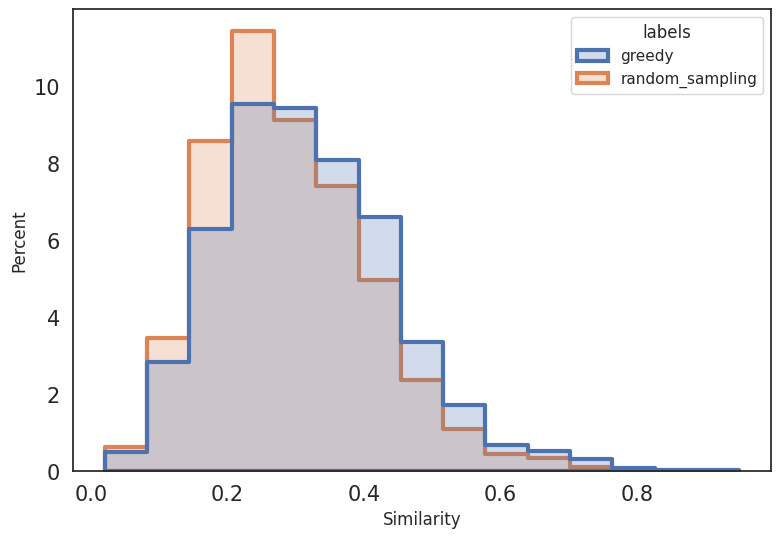

In [24]:
df = pd.DataFrame()
df['Similarity'] = sims
df['labels'] = sims_labels
%matplotlib inline
sns.set(rc={'figure.figsize':(9,6)})
sns.set_style("white")
sns.histplot(df, x='Similarity', hue='labels', bins=15, stat="percent", element="step", linewidth=3)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.savefig('tanimotosim.png', dpi=300)


In [20]:
from rdkit import Chem
from rdkit.Chem import RDConfig
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdDepictor, rdMolDraw2D
opts = Draw.DrawingOptions()
Draw.SetComicMode(opts)

img = Draw.MolsToGridImage(arr[60:80], molsPerRow=5, returnPNG=False)
img.save('Decoder_rdkit_vis.png' )

RuntimeError: Pre-condition Violation
	no draw context
	Violation occurred on line 214 in file Code/GraphMol/MolDraw2D/MolDraw2DCairo.cpp
	Failed Expression: dp_cr
	RDKIT: 2022.09.1
	BOOST: 1_78


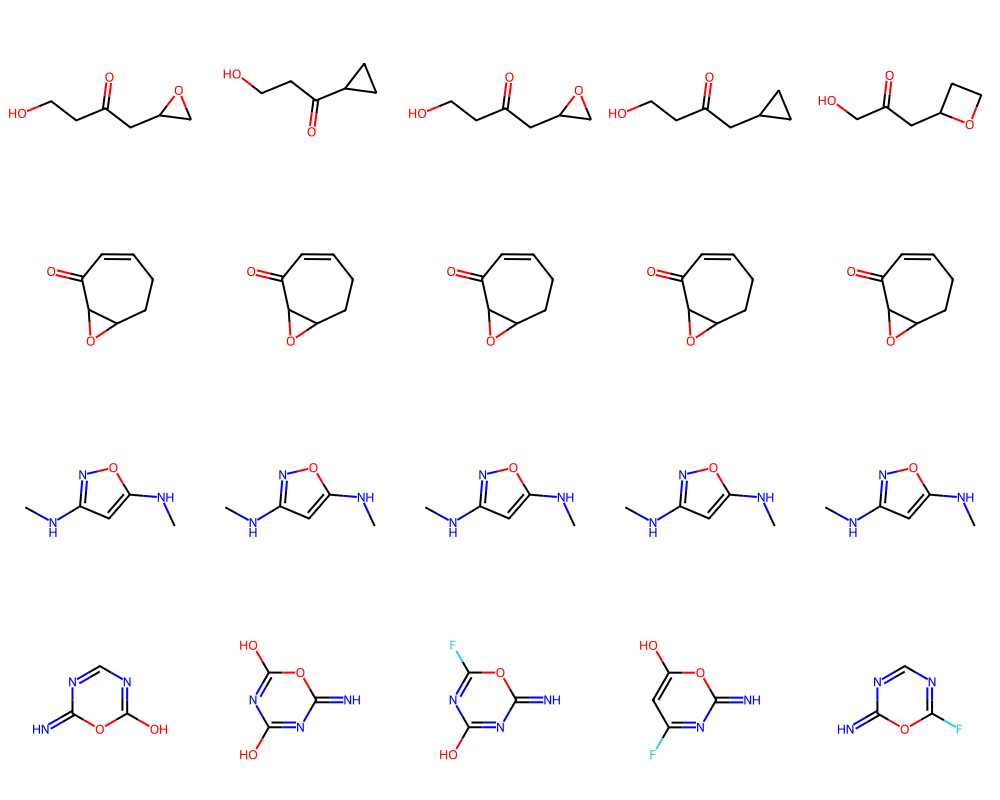

In [83]:
img

<AxesSubplot: xlabel='Similarity', ylabel='Count'>

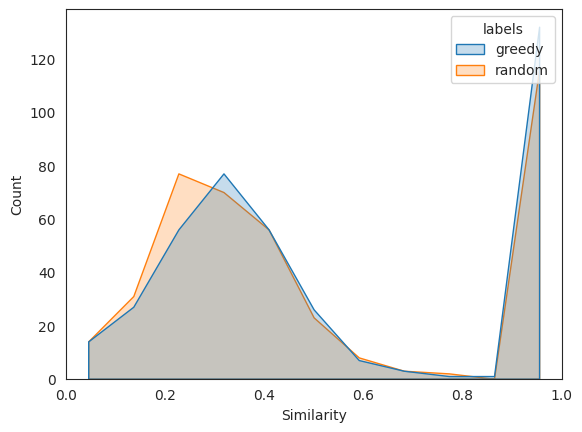

In [67]:
len(random_smiles_list[0])

3

In [68]:
len(arr)

0

RuntimeError: Pre-condition Violation
	no draw context
	Violation occurred on line 214 in file Code/GraphMol/MolDraw2D/MolDraw2DCairo.cpp
	Failed Expression: dp_cr
	RDKIT: 2022.09.1
	BOOST: 1_78
